# Sliding Window Combined with CNN for paddy field detection

# Preface

Original Article
**Using deep learning for paddy field detection from Google Earth images.**

*Shuntaro Watanabe, Kazuaki Sumi, Takeshi Ise*

doi: https://doi.org/10.1101/351643

**Note**

Without using specialized  networks like U-net, but with a general CNN for classification, we still can perform a segmentation. The concept originates from the "Patch-based Classification", proposed in the following paper. See the slide below. Combining a sliding window patches with repatative CNN classification allows detection of the tumor region.

Watanabe et al., performed a similar approach to segment paddy fields from satelite images retreived from google earth.
They express their method as "chopped images", however paying respect to the previous research, I describe this method as "Patch-based Classification" as I interpret the principle is identical. 


*Deep Learning for Identifying Metastatic Breast Cancer*

*Dayong Wang Aditya Khosla⋆ Rishab Gargeya Humayun Irshad Andrew H Beck Beth Israel Deaconess Medical Center, Harvard Medical School**
https://arxiv.org/abs/1606.05718
![image](https://raw.githubusercontent.com/totti0223/deep_learning_for_biologists_with_keras/master/assets/cancer.png)




# Import Libraries

In [4]:
!pip install slidingwindow
import slidingwindow as sw
import numpy as np
import os
import keras.backend as K
import keras
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from sklearn.utils.class_weight import compute_class_weight


Using TensorFlow backend.


# Download dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
## Download and extract dataset
!wget https://raw.githubusercontent.com/Gio1709/paddy/master/paddy.zip paddy.zip
!unzip -P paddy paddy.zip


--2019-10-16 00:17:13--  https://raw.githubusercontent.com/Gio1709/paddy/master/paddy.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3617909 (3.5M) [application/zip]
Saving to: ‘paddy.zip’

paddy.zip           100%[===================>]   3.45M  --.-KB/s    in 0.05s   

2019-10-16 00:17:13 (69.6 MB/s) - ‘paddy.zip’ saved [3617909/3617909]

--2019-10-16 00:17:13--  http://paddy.zip/
Resolving paddy.zip (paddy.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘paddy.zip’
FINISHED --2019-10-16 00:17:13--
Total wall clock time: 0.1s
Downloaded: 1 files, 3.5M in 0.05s (69.6 MB/s)
Archive:  paddy.zip
   creating: paddy/
  inflating: paddy/bamboopaddy_forest_detection.ipynb  
   creating: paddy/chopped/
   creating: paddy/test/
  infla

## Preview

In [5]:
!ls paddy/train
#image names starting with "b" is image with only paddy field.
#image names starting with "o" is image without paddy field.

b10.png  b13.png  b2.png  b5.png  b8.png   o1.png  o4.png  o7.png
b11.png  b14.png  b3.png  b6.png  b9.png   o2.png  o5.png  o8.png
b12.png  b1.png   b4.png  b7.png  o10.png  o3.png  o6.png  o9.png


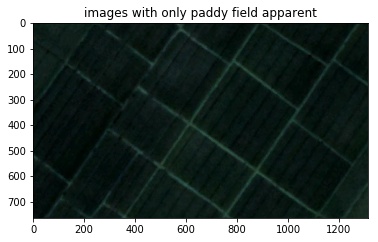

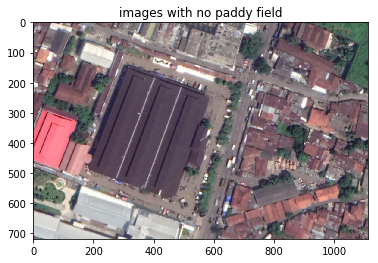

In [6]:
plt.title("images with only paddy field apparent")
plt.imshow(imread("paddy/train/b2.png"))
plt.show()

plt.title("images with no paddy field")
plt.imshow(imread("paddy/train/o10.png"))
plt.show()


# Create "patches" from each image using a sliding window

In [7]:
def save_to_folder(img_path,directory,size=56,overlap=0.4):
    #read imag from path save windows to the specified directory
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i,window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".png"
        _img = img[window.indices()]
        if _img.shape !=(size,size,3):
            continue
        img_target_path = os.path.join(directory,_fname)
        
        imsave(img_target_path,_img)
        
files = os.listdir("paddy/train/")
files = [x for x in files if x.endswith(".png")]

for file in files:
    save_directory = "paddy/chopped"
    file = os.path.join("paddy/train/",file)
    save_to_folder(file,save_directory)

/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/o8_00294.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/o8_00315.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/o8_00336.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/o8_00337.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/o8_00422.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: paddy/chopped/b8_00003.png is a low contrast image
  warn('%s is a low

In [8]:
files = os.listdir("paddy/chopped/")
files = [x for x in files if x.endswith(".png")]

x = []
y = []

for file in files:
    if file.startswith("b"):
        label = 1
    else:
        label = 0
    
    img_path = os.path.join("paddy/chopped",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

x = np.array(x)
y = np.array(y)
print(x.shape,y.shape)

(12983, 56, 56, 3) (12983,)


In [9]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(x,y,test_size=0.2,stratify = y)

print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(10386, 56, 56, 3)
(10386,)
(2597, 56, 56, 3)
(2597,)


In [10]:
#compute class weight
print(np.unique(train_y,return_counts=True))
print(np.unique(valid_y,return_counts=True))

cw = compute_class_weight("balanced",np.unique(train_y),train_y)
print(cw)

(array([0, 1]), array([5527, 4859]))
(array([0, 1]), array([1382, 1215]))
[0.93956939 1.06873842]


# Build and Train CNN

In [11]:
model = Sequential([
    layers.Conv2D(16,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),   
    layers.MaxPool2D((2,2),name="pool1"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool3"),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1),
    layers.Activation("sigmoid",name="prediction")
]
)

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 56, 56, 16)        448       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
____________________________________

In [17]:
history = model.fit(train_x,train_y,epochs=20,validation_data=(valid_x,valid_y),class_weight=cw)

Train on 10386 samples, validate on 2597 samples
Epoch 1/20
10386/10386 [==============================] - 5s 467us/step - loss: 6.2141e-04 - acc: 0.9998 - val_loss: 0.0257 - val_acc: 0.9946
Epoch 2/20
10386/10386 [==============================] - 5s 466us/step - loss: 1.6412e-04 - acc: 1.0000 - val_loss: 0.0144 - val_acc: 0.9961
Epoch 3/20
10386/10386 [==============================] - 5s 464us/step - loss: 0.0027 - acc: 0.9989 - val_loss: 0.0241 - val_acc: 0.9946
Epoch 4/20
10386/10386 [==============================] - 5s 466us/step - loss: 0.0026 - acc: 0.9994 - val_loss: 0.2149 - val_acc: 0.9677
Epoch 5/20
10386/10386 [==============================] - 5s 464us/step - loss: 0.0023 - acc: 0.9992 - val_loss: 0.0097 - val_acc: 0.9958
Epoch 6/20
10386/10386 [==============================] - 5s 466us/step - loss: 1.1354e-04 - acc: 1.0000 - val_loss: 0.0126 - val_acc: 0.9958
Epoch 7/20
10386/10386 [==============================] - 5s 451us/step - loss: 1.9398e-04 - acc: 1.0000 - val_

# Evaluate against Test Data

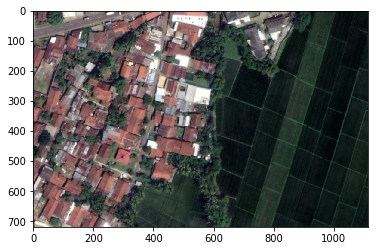

30
1410 30 47


In [18]:
#read test data
img_path = "paddy/test/test_image.png"
img = load_img(img_path)
img = img_to_array(img)/255
plt.imshow(img)
plt.show()

#create subimages
patches = []
windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)

#check total images, how many images are tiled at height direction, and width direction
n_total = len(windows)
_x = 0
for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x


print(n_total,n_x,n_total//n_x)

(1410, 1)
[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.9999993 ]
 [0.9999933 ]
 [0.99998486]]


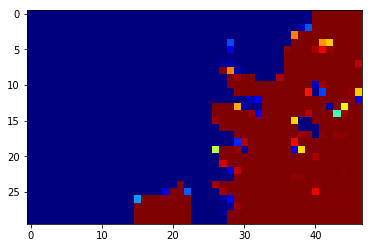

In [19]:
#predict the paddy probability for all the cropped images, and reshape back to its original form.
predictions = model.predict(patches)
print(predictions.shape)
print(predictions)

paddy = np.reshape(predictions,(n_total//n_x,n_x))
paddy = np.rot90(paddy)
paddy = np.flip(paddy,axis=0)
plt.imshow(paddy,cmap="jet")

note that each images correspond to 1 pixel of probability, and the size is not compatible with the input images.
we will caculate the ratio factor and resize it.

In [20]:
h_factor = img.shape[0]//paddy.shape[0]
w_factor = img.shape[1]//paddy.shape[1]
print(h_factor)

from scipy.ndimage import zoom
zoomed = zoom(paddy,(h_factor,w_factor))

print(zoomed.shape)

23
(690, 1081)


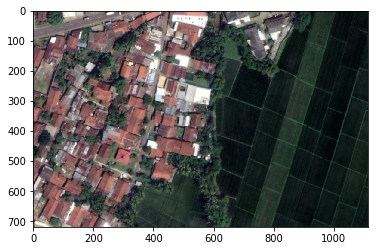

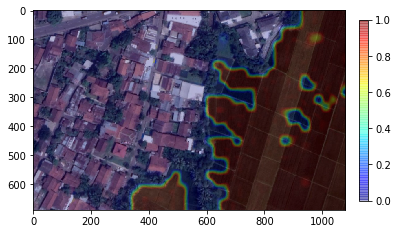

In [21]:
#result
plt.imshow(img)
plt.show()

plt.imshow(img)
plt.imshow(zoomed,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()